## $\mathbf{E}\times \mathbf{B}$ Drift
2D simulations of Single Particle Drifts
***

#### About the simulation

We will be using the 2D version of **ZPIC**. With this particle in cell code we are required to initialize a full plasma instead of a single particle. However, we may still track single particles and eliminate collective effects by decreasing the plasma density.

* Selecting a single particle ![alt text](https://github.com/adam-p/markdown-here/raw/master/src/common/images/icon48.png "Logo Title Text 1")




* Must use



In [129]:
import em2d
import numpy
import numpy as np
# Time step
dt = 0.01

# Simulation time
tmax = 22.8

# Number of cells
nx  = [64,32]

# Simulation box size
box = [6,3]


## Background plasma

# Particles per cell
ppc = [1,1]

dens=em2d.Density( type = "slab", start = 1.4,end=1.8)
dens.n=1e-6
# Use a step density profile
electrons = em2d.Species( "electrons", -1, ppc,
                           density = dens,ufl=[0.1,0,0])

dens2=em2d.Density( type = "slab", start = 1.4,end=1.8)
dens2.n=1e-6
positrons = em2d.Species( "positrons", 1, ppc,
                           density = dens2,ufl=[0.1,0,0])

# Initialize simulation
sim = em2d.Simulation( nx, box, dt, species = (electrons,positrons) )

B=1
E=0.01

def ext_B(x,y):
    return [0,0,B]

def ext_E(x,y):
    return [0,E,0]

ex=em2d.Ext_Field(sim,ext_E=ext_E,ext_B=ext_B)

#arays to store the particles trajectories
pos_part_rep =[]
ele_part_rep =[]

def itera():
    sim.current.zero()
    species=sim.get_species()
    for spec in species:
        spec.advance(sim)

    sim.current.update()
    sim.emf.advance(sim)
    ex.update_ext(sim)
    sim.advance()
    
    #store the electron trajectories
    ele_part_rep.append(sim.get_species()[0].particles[64].copy())
    #store the positron(ish) trajectories
    pos_part_rep.append(sim.get_species()[1].particles[56].copy())


while sim.t < 2*1.8*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    itera()

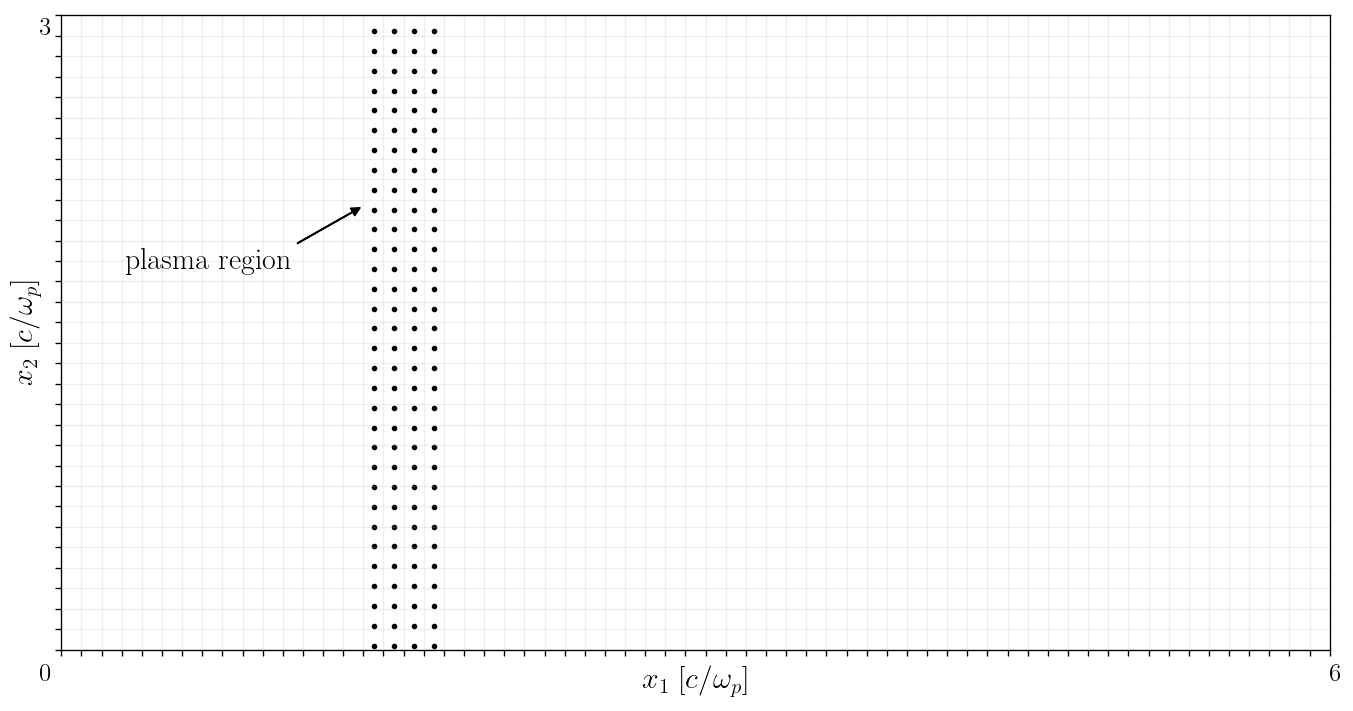

In [141]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(14, 7), dpi=120)
ax=plt.gca()
import matplotlib as mpl
plt.rcParams.update({'font.size': 18})
mpl.rc('text', usetex = 'True')
mpl.rc('font', family = 'serif')

xese=(electrons.particles[:]['ix']+electrons.particles[:]['x'])*box[0]/nx[0]
yes=(electrons.particles[:]['iy']+electrons.particles[:]['y'])*box[0]/nx[0]
ax.scatter(xese,yes,s=5.5,c="k")


#ax.scatter(xese[64],yes[64],s=13,marker="s",c='red')
#ax.scatter(xese[56],yes[56],s=13,marker="s",c='red')


ax.set_xlim(0,box[0])
ax.set_ylim(0,box[1])
ax.set_xticks(np.linspace(0,box[0],nx[0]))
ax.set_yticks(np.linspace(0,box[1],nx[1]))
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(-0.1, -0.15, r'0', fontsize=15)
ax.text(6, -0.15, r'6', fontsize=15)
ax.text(-0.1, 2.91, r'3', fontsize=15)

ax.annotate('plasma region', xy=(1.43, 2.1), xytext=(0.3, 1.8),
            arrowprops=dict(facecolor='black', shrink=0.05,width=0.2,headwidth=5,headlength=5))


#ax.annotate('particle 64', xy=(1.43, 1.62), xytext=(0.3, 1.8),
#            arrowprops=dict(facecolor='black', shrink=0.05,width=0.2,headwidth=5,headlength=5))

ax.set_aspect('equal')
ax.grid(alpha=0.2)
ax.set_xlabel("$x_1\;[c/\omega_p]$")
ax.set_ylabel("$x_2\;[c/\omega_p]$")
plt.savefig("plasm.png")
#plt.savefig("part.png")

In [4]:
electrons.particles[:]['ix']

array([68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68,
       69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69,
       68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68,
       69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69, 68, 69], dtype=int32)

In [86]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

p_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in pos_part_rep]
p_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in pos_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)

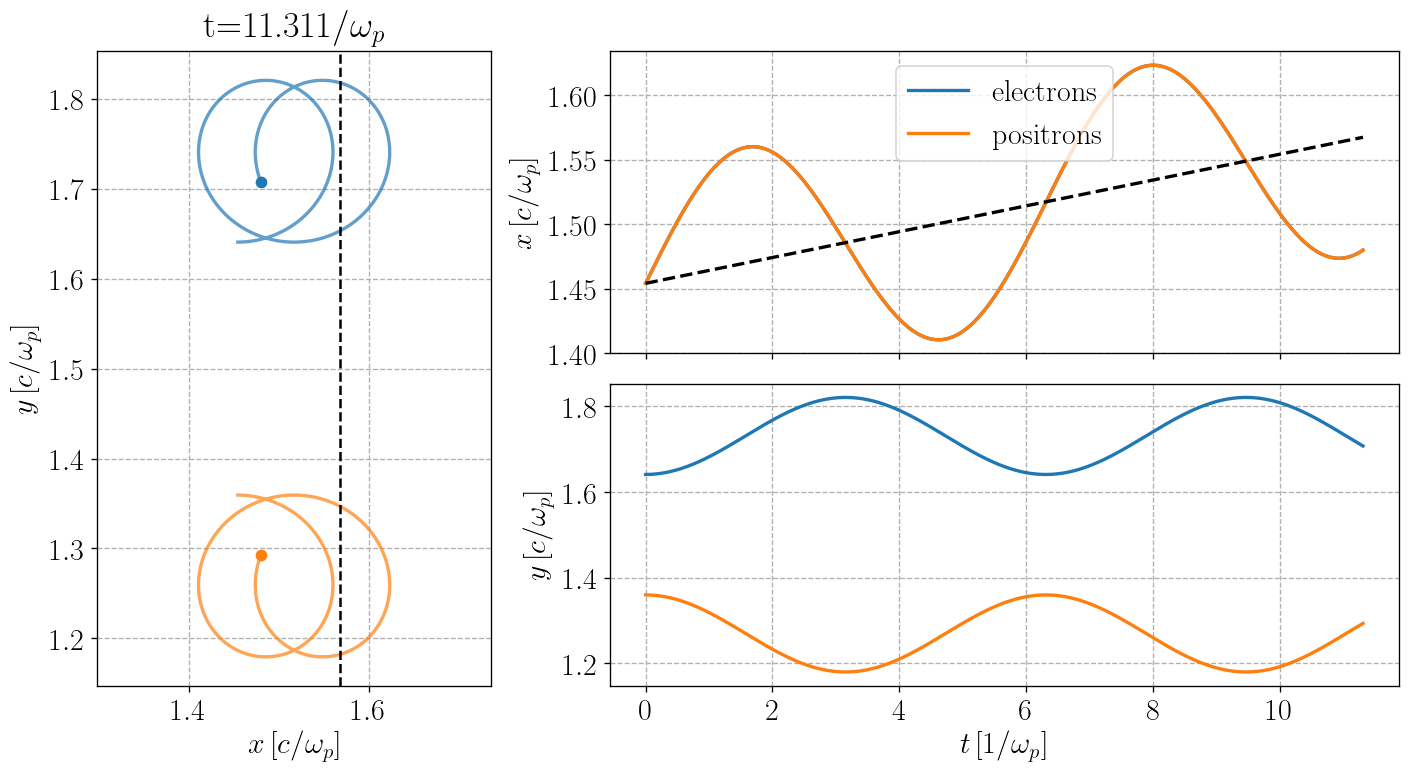

In [87]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})
mpl.rc('text', usetex = 'True')
mpl.rc('font', family = 'serif')

gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[1, 2])

ax = plt.subplot(gs2[:, 0])
ax.plot(e_posx_t,e_posy_t,lw=2,alpha=0.7)
ax.scatter(e_posx_t[-1],e_posy_t[-1])
ax.plot(p_posx_t,p_posy_t,lw=2,alpha=0.7)
ax.scatter(p_posx_t[-1],p_posy_t[-1])
ax.grid(True,ls="--")
ax.set_xlabel("$x\,[c/\omega_p]$")
plt.axvline(E/B*sim.t+e_posx_t[0],c='k',ls='--')
ax.set_ylabel("$y\,[c/\omega_p]$")
ax.set_aspect('equal', 'datalim')
ax.set_title("t={:.2f}$1/\omega_p$".format(sim.t))

ax2 = plt.subplot(gs2[0,1])
ax2.plot(t,e_posx_t,lw=2,label="electrons")
ax2.plot(t,p_posx_t,lw=2,label="positrons")
ax2.plot(t,E/B*t+e_posx_t[0],lw=2,c='k',ls='--')
ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("$x\,[c/\omega_p]$")
ax2.legend()

ax3 = plt.subplot(gs2[1,1])
ax3.plot(t,e_posy_t,lw=2)
ax3.plot(t,p_posy_t,lw=2)
ax3.set_ylabel("$y\,[c/\omega_p]$")
ax3.set_xlabel("$t\,[1/\omega_p]$")
ax3.grid(True,ls="--")
plt.show()

In [161]:
while sim.t < 2*1.75*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    itera()

In [163]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

p_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in pos_part_rep]
p_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in pos_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)

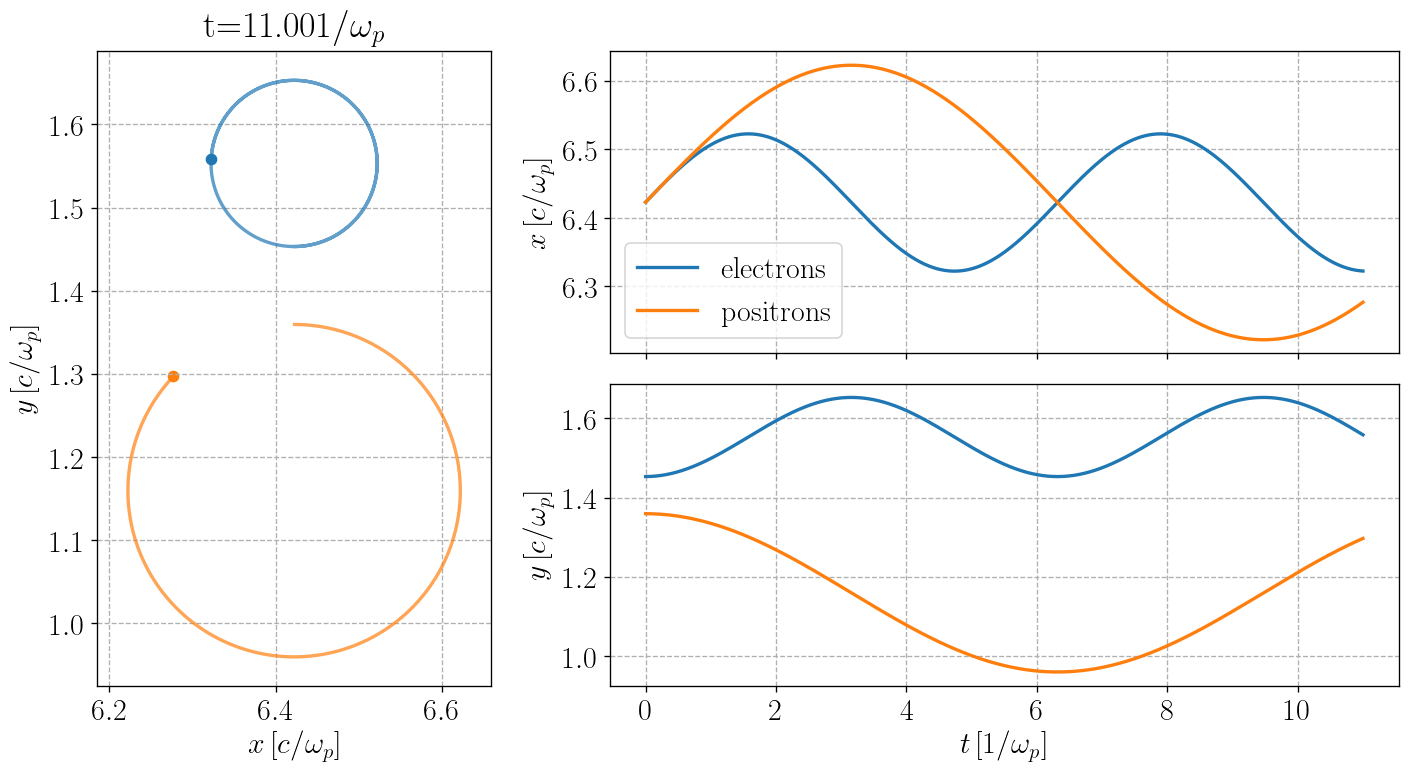

In [166]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})
mpl.rc('text', usetex = 'True')
mpl.rc('font', family = 'serif')

gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[1, 2])

ax = plt.subplot(gs2[:, 0])
ax.plot(e_posx_t,e_posy_t,lw=2,alpha=0.7)
ax.scatter(e_posx_t[-1],e_posy_t[-1])
ax.plot(p_posx_t,p_posy_t,lw=2,alpha=0.7)
ax.scatter(p_posx_t[-1],p_posy_t[-1])
ax.grid(True,ls="--")
ax.set_xlabel("$x\,[c/\omega_p]$")
ax.set_ylabel("$y\,[c/\omega_p]$")
ax.set_aspect('equal', 'datalim')
ax.set_title("t={:.2f}$1/\omega_p$".format(sim.t))

ax2 = plt.subplot(gs2[0,1])
ax2.plot(t,e_posx_t,lw=2,label="electrons")
ax2.plot(t,p_posx_t,lw=2,label="positrons")
ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("$x\,[c/\omega_p]$")
ax2.legend()

ax3 = plt.subplot(gs2[1,1])
ax3.plot(t,e_posy_t,lw=2)
ax3.plot(t,p_posy_t,lw=2)
ax3.set_ylabel("$y\,[c/\omega_p]$")
ax3.set_xlabel("$t\,[1/\omega_p]$")
ax3.grid(True,ls="--")
plt.show()